In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,classification_report,roc_curve, auc
import glob
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
list_dir =glob.glob("/Users/Gaia_1/Desktop/tesi/Data after PP scores/*.txt")

# List to hold individual DataFrames
dfs = []

# Iterate through each file in the directory
for file in list_dir:
    # Read the file into a DataFrame
    #file_path = os.path.join(directory, filename)
    df = pd.read_csv(file) #, delimiter='\t')  # Assuming tab-separated values
    dfs.append(df)

# Merge all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame as CSV
merged_df.to_csv("merged_data.csv", index=False)
dataset=merged_df
dataset


,Unnamed: 0,mu1,lam1,mu2,sigma2,mu3,sigma3,w1,w2,w3,score,Target,Stimulation
0,0,0.033752,0.026832,6.146017e-02,0.030909,0.383788,0.344440,1.000000,1.460269e-07,3.546668e-08,0.064030,0.0,0.0
1,0,0.033134,0.026059,6.314898e-02,0.036732,0.386172,0.350197,1.000000,1.033784e-08,5.968611e-09,0.068225,0.0,0.0
2,0,0.033298,0.026767,6.708787e-02,0.046021,0.386777,0.349459,1.000000,1.959580e-07,9.157318e-08,0.061535,0.0,0.0
3,0,0.033493,0.026519,6.282182e-02,0.030459,0.383312,0.341055,1.000000,9.648819e-08,3.575563e-08,0.061335,0.0,0.0
4,0,0.032974,0.025866,6.308468e-02,0.033693,0.385092,0.347405,1.000000,4.407161e-08,1.683473e-08,0.062659,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,0,0.050616,0.026634,2.284669e-02,0.096958,0.315152,0.163408,0.543656,4.563435e-01,5.968653e-08,0.193786,0.0,0.0
807,0,0.057557,0.028160,5.235134e-02,0.069468,0.321707,0.192334,0.575948,4.240515e-01,1.911695e-07,0.113257,0.0,0.0
808,0,0.053260,0.031083,5.737179e-07,0.108185,0.248023,0.060402,0.445422,5.545780e-01,9.840582e-16,0.284483,0.0,0.0
809,0,0.048749,0.026283,3.671914e-07,0.111340,0.312674,0.154662,0.451368,5.486318e-01,3.613233e-09,0.282560,0.0,0.0


dataset = pd.read_csv('Data after PP/Data')

### Only baseline

In [66]:
dataset = dataset[dataset['Stimulation'] != 1]
dataset

,Unnamed: 0,mu1,lam1,mu2,sigma2,mu3,sigma3,w1,w2,w3,Target,Stimulation
0,0,0.029989,0.023791,0.050000,0.025455,0.301780,0.317919,0.814444,0.185555,4.704015e-07,0.0,1.0
1,0,0.030000,0.023087,0.050000,0.025142,0.273312,0.328372,0.813396,0.186604,3.058176e-12,0.0,1.0
2,0,0.028645,0.024061,0.050000,0.029190,0.180386,0.221539,0.804252,0.195748,2.771986e-30,0.0,1.0
3,0,0.030000,0.024694,0.050000,0.017556,0.272991,0.290797,0.918604,0.081396,5.773332e-11,0.0,1.0
4,0,0.030000,0.024102,0.051366,0.010000,0.255269,0.292689,0.917414,0.082586,2.747613e-15,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,0,0.030000,0.022657,0.050000,0.027277,0.100001,0.057532,0.583097,0.257282,1.596210e-01,0.0,1.0
433,0,0.030000,0.023670,0.050000,0.040929,0.240133,0.240503,0.661024,0.338976,5.419047e-10,0.0,1.0
434,0,0.030000,0.023743,0.050000,0.046941,0.221648,0.150496,0.660084,0.339913,2.286516e-06,0.0,1.0
435,0,0.030000,0.023481,0.050000,0.024746,0.100007,0.050629,0.634492,0.266342,9.916566e-02,0.0,1.0


### Dropping stimulation column

In [3]:
dataset=dataset.drop(['Stimulation'],axis=1)
dataset=dataset.drop(['score'],axis=1)
dataset = dataset.drop(['Unnamed: 0'],axis=1)

In [4]:
dataset['Target'].value_counts()

0.0    406
1.0    405
Name: Target, dtype: int64

In [5]:
dataset['Target'].value_counts(1)

0.0    0.500617
1.0    0.499383
Name: Target, dtype: float64

In [6]:
X = dataset.drop(['Target'],axis=1)
y= dataset['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)

# Standardization

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# CV

In [7]:
cv = StratifiedKFold(4)

# PCA

pca = PCA(n_components=7,svd_solver='full')
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(pca.fit(X_train).explained_variance_ratio_)
#print(cum_sum((pca.fit(X_train).explained_variance_ratio_)))

# Classification Tree

In [8]:
params = {'max_depth':np.linspace(2,10,dtype='int'),'criterion':['gini','entropy']}

clf = DecisionTreeClassifier(random_state=12)

gs_ct = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_ct=gs_ct.fit(X_train,y_train)
y_true, y_pred = y_test, gs_ct.predict(X_test)
#gs_pca = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)
#gs_pca = gs_pca.fit(X_train_pca,y_train)

## CT metrics

In [9]:
print("Best parameters set found :",gs_ct.best_params_,'\n')
print("Classification report on Test set\n")

roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)

class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

'''print('\n\n Result with PCA\n')
print("Best parameters set found :",gs_pca.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_pca.predict(X_test_pca)

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)
'''

Best parameters set found : {'criterion': 'entropy', 'max_depth': 3} 

Classification report on Test set

ROC AUC:  0.971
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       122
         1.0       0.98      0.96      0.97       122

    accuracy                           0.97       244
   macro avg       0.97      0.97      0.97       244
weighted avg       0.97      0.97      0.97       244



'print(\'\n\n Result with PCA\n\')\nprint("Best parameters set found :",gs_pca.best_params_,\'\n\')\nprint("Classification report on Test set\n")\n\ny_true, y_pred = y_test, gs_pca.predict(X_test_pca)\n\naccuracy = round(accuracy_score(y_true, y_pred),3)\nrecall = round(recall_score(y_true, y_pred),3)\nprecision = round(precision_score(y_true, y_pred),3)\nroc_auc = round(roc_auc_score(y_true, y_pred),3)\n\nprint(\'Accuracy: \',accuracy)\nprint(\'Recall: \',recall)\nprint(\'Precision: \',precision)\nprint(\'ROC AUC: \',roc_auc)\n'

In [10]:
accuracy_ct = round(accuracy_score(y_true, y_pred),3)
recall_ct = round(recall_score(y_true, y_pred),3)
precision_ct = round(precision_score(y_true, y_pred),3)
roc_auc_ct = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_ct)
print('Recall: ',recall_ct)
print('Precision: ',precision_ct)
print('ROC AUC: ',roc_auc_ct)

Accuracy:  0.971
Recall:  0.959
Precision:  0.983
ROC AUC:  0.971


## CT matrix

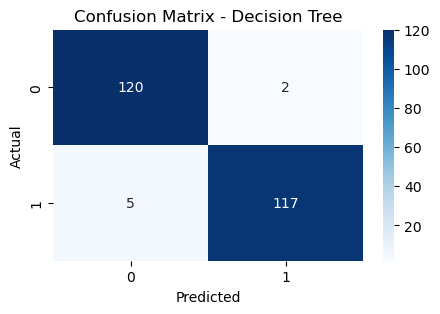

In [11]:
# Assuming clf is your trained DecisionTreeClassifier
y_pred = gs_ct.predict(X_test)  # Use gs instead of clf if you want to use the grid search optimized model

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


## CT feature info

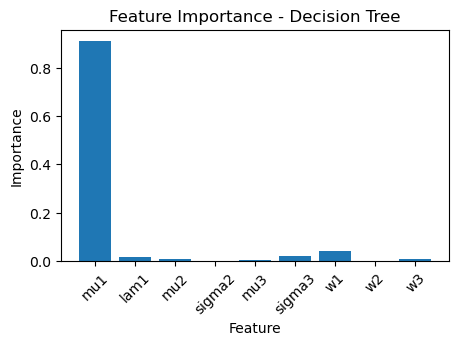

In [12]:
# Assuming X_train is your feature matrix and y_train is your target
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Plot feature importance
plt.figure(figsize=(5, 3))
plt.bar(X.columns, tree.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Decision Tree')
plt.xticks(rotation=45)
plt.show()


## ROC Curve

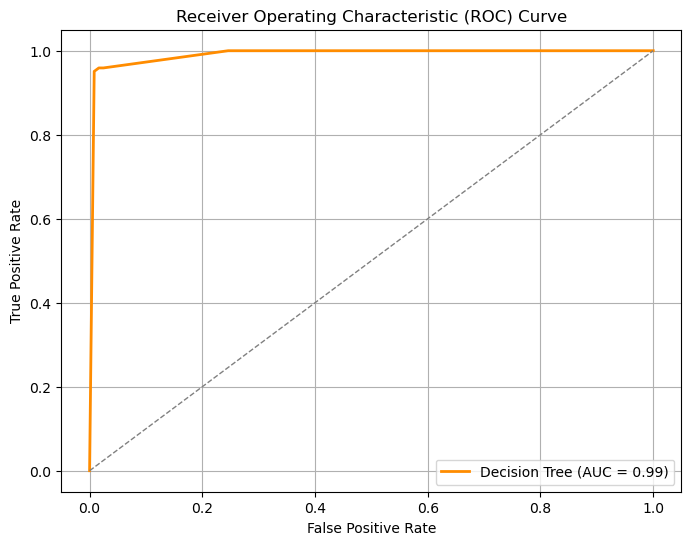

In [13]:
y_score_ct = gs_ct.predict_proba(X_test)[:,1]
fpr_ct, tpr_ct, _ = roc_curve(y_test, y_score_ct)
roc_auc_ct = auc(fpr_ct, tpr_ct)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_ct:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Random Forest

In [14]:
params = {'n_estimators':np.linspace(10,150,dtype='int',num=10),'max_depth':np.linspace(2,5,dtype='int'),'criterion':['gini','entropy']}

clf = RandomForestClassifier(n_jobs=-1,random_state=12)

gs_rf = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,verbose=10,n_jobs=-1)

gs_rf=gs_rf.fit(X_train,y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
[CV 2/4; 1/1000] START criterion=gini, max_depth=2, n_estimators=10.............
[CV 2/4; 1/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.994 total time=   0.1s
[CV 2/4; 2/1000] START criterion=gini, max_depth=2, n_estimators=25.............
[CV 2/4; 2/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.995 total time=   0.1s
[CV 1/4; 3/1000] START criterion=gini, max_depth=2, n_estimators=41.............
[CV 1/4; 3/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.999 total time=   0.3s
[CV 2/4; 3/1000] START criterion=gini, max_depth=2, n_estimators=41.............
[CV 2/4; 3/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.995 total time=   0.2s
[CV 3/4; 5/1000] START criterion=gini, max_depth=2, n_estimators=72.............
[CV 3/4; 5/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.988 total time=   0.3s
[CV 4/4; 5/1000] START criterion=gi

[CV 3/4; 1/1000] START criterion=gini, max_depth=2, n_estimators=10.............
[CV 3/4; 1/1000] END criterion=gini, max_depth=2, n_estimators=10;, score=0.987 total time=   0.1s
[CV 3/4; 2/1000] START criterion=gini, max_depth=2, n_estimators=25.............
[CV 3/4; 2/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.987 total time=   0.2s
[CV 1/4; 4/1000] START criterion=gini, max_depth=2, n_estimators=56.............
[CV 1/4; 4/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.999 total time=   0.2s
[CV 2/4; 4/1000] START criterion=gini, max_depth=2, n_estimators=56.............
[CV 2/4; 4/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.995 total time=   0.3s
[CV 3/4; 6/1000] START criterion=gini, max_depth=2, n_estimators=87.............
[CV 3/4; 6/1000] END criterion=gini, max_depth=2, n_estimators=87;, score=0.989 total time=   0.3s
[CV 4/4; 6/1000] START criterion=gini, max_depth=2, n_estimators=87.............
[CV 4/4; 6/1000] EN

[CV 3/4; 82/1000] START criterion=gini, max_depth=2, n_estimators=25............
[CV 3/4; 82/1000] END criterion=gini, max_depth=2, n_estimators=25;, score=0.987 total time=   0.2s
[CV 4/4; 83/1000] START criterion=gini, max_depth=2, n_estimators=41............
[CV 4/4; 83/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=1.000 total time=   0.3s
[CV 4/4; 84/1000] START criterion=gini, max_depth=2, n_estimators=56............
[CV 4/4; 84/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=1.000 total time=   0.4s
[CV 4/4; 85/1000] START criterion=gini, max_depth=2, n_estimators=72............
[CV 4/4; 85/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=1.000 total time=   0.4s
[CV 4/4; 86/1000] START criterion=gini, max_depth=2, n_estimators=87............
[CV 4/4; 86/1000] END criterion=gini, max_depth=2, n_estimators=87;, score=1.000 total time=   0.5s
[CV 4/4; 87/1000] START criterion=gini, max_depth=2, n_estimators=103...........
[CV 4/4; 87/10

[CV 4/4; 96/1000] START criterion=gini, max_depth=2, n_estimators=87............
[CV 4/4; 96/1000] END criterion=gini, max_depth=2, n_estimators=87;, score=1.000 total time=   0.4s
[CV 4/4; 97/1000] START criterion=gini, max_depth=2, n_estimators=103...........
[CV 4/4; 97/1000] END criterion=gini, max_depth=2, n_estimators=103;, score=1.000 total time=   0.5s
[CV 4/4; 98/1000] START criterion=gini, max_depth=2, n_estimators=118...........
[CV 4/4; 98/1000] END criterion=gini, max_depth=2, n_estimators=118;, score=1.000 total time=   0.5s
[CV 4/4; 99/1000] START criterion=gini, max_depth=2, n_estimators=134...........
[CV 4/4; 99/1000] END criterion=gini, max_depth=2, n_estimators=134;, score=1.000 total time=   0.6s
[CV 4/4; 100/1000] START criterion=gini, max_depth=2, n_estimators=150..........
[CV 4/4; 100/1000] END criterion=gini, max_depth=2, n_estimators=150;, score=1.000 total time=   0.7s
[CV 3/4; 102/1000] START criterion=gini, max_depth=2, n_estimators=25...........
[CV 3/4; 

[CV 3/4; 103/1000] START criterion=gini, max_depth=2, n_estimators=41...........
[CV 3/4; 103/1000] END criterion=gini, max_depth=2, n_estimators=41;, score=0.987 total time=   0.2s
[CV 3/4; 104/1000] START criterion=gini, max_depth=2, n_estimators=56...........
[CV 3/4; 104/1000] END criterion=gini, max_depth=2, n_estimators=56;, score=0.988 total time=   0.3s
[CV 2/4; 105/1000] START criterion=gini, max_depth=2, n_estimators=72...........
[CV 2/4; 105/1000] END criterion=gini, max_depth=2, n_estimators=72;, score=0.995 total time=   0.4s
[CV 3/4; 106/1000] START criterion=gini, max_depth=2, n_estimators=87...........
[CV 3/4; 106/1000] END criterion=gini, max_depth=2, n_estimators=87;, score=0.989 total time=   0.4s
[CV 3/4; 107/1000] START criterion=gini, max_depth=2, n_estimators=103..........
[CV 3/4; 107/1000] END criterion=gini, max_depth=2, n_estimators=103;, score=0.989 total time=   0.4s
[CV 2/4; 108/1000] START criterion=gini, max_depth=2, n_estimators=118..........
[CV 2/4;

[CV 2/4; 171/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.994 total time=   0.1s
[CV 1/4; 172/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 1/4; 172/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.999 total time=   0.1s
[CV 1/4; 173/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 1/4; 173/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.999 total time=   0.2s
[CV 3/4; 174/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 3/4; 174/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.988 total time=   0.3s
[CV 1/4; 175/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 1/4; 175/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=0.999 total time=   0.4s
[CV 3/4; 176/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 3/4; 176/1000] END criterion=gini, max_depth=3, n_estimators=87;, score=0.989 total ti

[CV 2/4; 190/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 2/4; 190/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.997 total time=   0.8s
[CV 3/4; 192/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 3/4; 192/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.988 total time=   0.1s
[CV 3/4; 193/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 3/4; 193/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.988 total time=   0.2s
[CV 1/4; 194/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 1/4; 194/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.999 total time=   0.3s
[CV 2/4; 195/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 2/4; 195/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=0.997 total time=   0.4s
[CV 1/4; 196/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 1/4;

[CV 3/4; 188/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 3/4; 188/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.989 total time=   0.6s
[CV 2/4; 189/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 2/4; 189/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.997 total time=   0.7s
[CV 3/4; 190/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 3/4; 190/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.991 total time=   0.7s
[CV 1/4; 191/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 1/4; 191/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.999 total time=   0.1s
[CV 4/4; 191/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 4/4; 191/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.999 total time=   0.1s
[CV 4/4; 192/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 4/

[CV 3/4; 257/1000] END criterion=gini, max_depth=3, n_estimators=103;, score=0.989 total time=   0.5s
[CV 3/4; 258/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 3/4; 258/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.989 total time=   0.5s
[CV 2/4; 259/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 2/4; 259/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.997 total time=   0.6s
[CV 2/4; 260/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 2/4; 260/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.997 total time=   0.6s
[CV 3/4; 261/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 3/4; 261/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.988 total time=   0.1s
[CV 2/4; 262/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 2/4; 262/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.996 tota

[CV 2/4; 258/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.997 total time=   0.6s
[CV 3/4; 259/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 3/4; 259/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.991 total time=   0.5s
[CV 1/4; 260/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 1/4; 260/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.999 total time=   0.8s
[CV 4/4; 262/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 4/4; 262/1000] END criterion=gini, max_depth=3, n_estimators=25;, score=0.999 total time=   0.1s
[CV 3/4; 263/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 3/4; 263/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.988 total time=   0.2s
[CV 2/4; 264/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 2/4; 264/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=0.997 total

[CV 2/4; 278/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 2/4; 278/1000] END criterion=gini, max_depth=3, n_estimators=118;, score=0.997 total time=   0.5s
[CV 2/4; 279/1000] START criterion=gini, max_depth=3, n_estimators=134..........
[CV 2/4; 279/1000] END criterion=gini, max_depth=3, n_estimators=134;, score=0.997 total time=   0.6s
[CV 2/4; 280/1000] START criterion=gini, max_depth=3, n_estimators=150..........
[CV 2/4; 280/1000] END criterion=gini, max_depth=3, n_estimators=150;, score=0.997 total time=   0.7s
[CV 1/4; 281/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 1/4; 281/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.999 total time=   0.1s
[CV 3/4; 281/1000] START criterion=gini, max_depth=3, n_estimators=10...........
[CV 3/4; 281/1000] END criterion=gini, max_depth=3, n_estimators=10;, score=0.988 total time=   0.1s
[CV 3/4; 282/1000] START criterion=gini, max_depth=3, n_estimators=25...........
[CV 3/

[CV 4/4; 283/1000] START criterion=gini, max_depth=3, n_estimators=41...........
[CV 4/4; 283/1000] END criterion=gini, max_depth=3, n_estimators=41;, score=0.999 total time=   0.2s
[CV 4/4; 284/1000] START criterion=gini, max_depth=3, n_estimators=56...........
[CV 4/4; 284/1000] END criterion=gini, max_depth=3, n_estimators=56;, score=1.000 total time=   0.3s
[CV 4/4; 285/1000] START criterion=gini, max_depth=3, n_estimators=72...........
[CV 4/4; 285/1000] END criterion=gini, max_depth=3, n_estimators=72;, score=1.000 total time=   0.4s
[CV 4/4; 286/1000] START criterion=gini, max_depth=3, n_estimators=87...........
[CV 4/4; 286/1000] END criterion=gini, max_depth=3, n_estimators=87;, score=1.000 total time=   0.4s
[CV 4/4; 287/1000] START criterion=gini, max_depth=3, n_estimators=103..........
[CV 4/4; 287/1000] END criterion=gini, max_depth=3, n_estimators=103;, score=1.000 total time=   0.5s
[CV 4/4; 288/1000] START criterion=gini, max_depth=3, n_estimators=118..........
[CV 4/4;

[CV 1/4; 345/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=0.999 total time=   0.4s
[CV 1/4; 346/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 1/4; 346/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.999 total time=   0.4s
[CV 1/4; 347/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 1/4; 347/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.999 total time=   0.5s
[CV 3/4; 348/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 3/4; 348/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.987 total time=   0.5s
[CV 4/4; 349/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 4/4; 349/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=1.000 total time=   0.6s
[CV 4/4; 350/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 4/4; 350/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=1.000 tota

[CV 2/4; 362/1000] START criterion=gini, max_depth=4, n_estimators=25...........
[CV 2/4; 362/1000] END criterion=gini, max_depth=4, n_estimators=25;, score=0.998 total time=   0.1s
[CV 1/4; 363/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 1/4; 363/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=0.999 total time=   0.2s
[CV 4/4; 363/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 4/4; 363/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=1.000 total time=   0.2s
[CV 3/4; 364/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 3/4; 364/1000] END criterion=gini, max_depth=4, n_estimators=56;, score=0.987 total time=   0.3s
[CV 4/4; 365/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 4/4; 365/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=1.000 total time=   0.3s
[CV 3/4; 366/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 3/4; 

[CV 2/4; 380/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 2/4; 380/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=0.997 total time=   0.6s
[CV 1/4; 381/1000] START criterion=gini, max_depth=4, n_estimators=10...........
[CV 1/4; 381/1000] END criterion=gini, max_depth=4, n_estimators=10;, score=0.999 total time=   0.1s
[CV 4/4; 381/1000] START criterion=gini, max_depth=4, n_estimators=10...........
[CV 4/4; 381/1000] END criterion=gini, max_depth=4, n_estimators=10;, score=0.999 total time=   0.1s
[CV 3/4; 382/1000] START criterion=gini, max_depth=4, n_estimators=25...........
[CV 3/4; 382/1000] END criterion=gini, max_depth=4, n_estimators=25;, score=0.991 total time=   0.1s
[CV 3/4; 383/1000] START criterion=gini, max_depth=4, n_estimators=41...........
[CV 3/4; 383/1000] END criterion=gini, max_depth=4, n_estimators=41;, score=0.987 total time=   0.2s
[CV 3/4; 384/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 3/4;

[CV 3/4; 436/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.987 total time=   0.4s
[CV 1/4; 437/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 1/4; 437/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.999 total time=   0.4s
[CV 2/4; 438/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 2/4; 438/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.997 total time=   0.5s
[CV 2/4; 439/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 2/4; 439/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.997 total time=   0.5s
[CV 1/4; 440/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 1/4; 440/1000] END criterion=gini, max_depth=4, n_estimators=150;, score=0.999 total time=   0.6s
[CV 1/4; 441/1000] START criterion=gini, max_depth=4, n_estimators=10...........
[CV 1/4; 441/1000] END criterion=gini, max_depth=4, n_estimators=10;, score=0.999 tota

[CV 4/4; 465/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 4/4; 465/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=1.000 total time=   0.3s
[CV 4/4; 466/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 4/4; 466/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=1.000 total time=   0.4s
[CV 3/4; 467/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 3/4; 467/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.987 total time=   0.4s
[CV 3/4; 468/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 3/4; 468/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.987 total time=   0.5s
[CV 3/4; 469/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 3/4; 469/1000] END criterion=gini, max_depth=4, n_estimators=134;, score=0.987 total time=   0.6s
[CV 3/4; 470/1000] START criterion=gini, max_depth=4, n_estimators=150..........
[CV 3/

[CV 1/4; 454/1000] START criterion=gini, max_depth=4, n_estimators=56...........
[CV 1/4; 454/1000] END criterion=gini, max_depth=4, n_estimators=56;, score=0.999 total time=   0.3s
[CV 2/4; 455/1000] START criterion=gini, max_depth=4, n_estimators=72...........
[CV 2/4; 455/1000] END criterion=gini, max_depth=4, n_estimators=72;, score=0.997 total time=   0.3s
[CV 2/4; 456/1000] START criterion=gini, max_depth=4, n_estimators=87...........
[CV 2/4; 456/1000] END criterion=gini, max_depth=4, n_estimators=87;, score=0.997 total time=   0.4s
[CV 3/4; 457/1000] START criterion=gini, max_depth=4, n_estimators=103..........
[CV 3/4; 457/1000] END criterion=gini, max_depth=4, n_estimators=103;, score=0.987 total time=   0.4s
[CV 3/4; 458/1000] START criterion=gini, max_depth=4, n_estimators=118..........
[CV 3/4; 458/1000] END criterion=gini, max_depth=4, n_estimators=118;, score=0.987 total time=   0.5s
[CV 1/4; 459/1000] START criterion=gini, max_depth=4, n_estimators=134..........
[CV 1/4

[CV 1/4; 527/1000] END criterion=entropy, max_depth=2, n_estimators=103;, score=0.999 total time=   0.4s
[CV 1/4; 528/1000] START criterion=entropy, max_depth=2, n_estimators=118.......
[CV 1/4; 528/1000] END criterion=entropy, max_depth=2, n_estimators=118;, score=0.999 total time=   0.5s
[CV 2/4; 529/1000] START criterion=entropy, max_depth=2, n_estimators=134.......
[CV 2/4; 529/1000] END criterion=entropy, max_depth=2, n_estimators=134;, score=0.997 total time=   0.5s
[CV 2/4; 530/1000] START criterion=entropy, max_depth=2, n_estimators=150.......
[CV 2/4; 530/1000] END criterion=entropy, max_depth=2, n_estimators=150;, score=0.996 total time=   0.6s
[CV 1/4; 531/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 1/4; 531/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=1.000 total time=   0.1s
[CV 3/4; 531/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 3/4; 531/1000] END criterion=entropy, max_depth=2, n_estimators=10;

[CV 4/4; 547/1000] END criterion=entropy, max_depth=2, n_estimators=103;, score=1.000 total time=   0.5s
[CV 4/4; 548/1000] START criterion=entropy, max_depth=2, n_estimators=118.......
[CV 4/4; 548/1000] END criterion=entropy, max_depth=2, n_estimators=118;, score=1.000 total time=   0.6s
[CV 4/4; 549/1000] START criterion=entropy, max_depth=2, n_estimators=134.......
[CV 4/4; 549/1000] END criterion=entropy, max_depth=2, n_estimators=134;, score=1.000 total time=   0.6s
[CV 4/4; 550/1000] START criterion=entropy, max_depth=2, n_estimators=150.......
[CV 4/4; 550/1000] END criterion=entropy, max_depth=2, n_estimators=150;, score=1.000 total time=   0.8s
[CV 2/4; 554/1000] START criterion=entropy, max_depth=2, n_estimators=56........
[CV 2/4; 554/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.995 total time=   0.2s
[CV 2/4; 555/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 2/4; 555/1000] END criterion=entropy, max_depth=2, n_estimators=72;

[CV 3/4; 614/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.989 total time=   0.3s
[CV 3/4; 615/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 3/4; 615/1000] END criterion=entropy, max_depth=2, n_estimators=72;, score=0.990 total time=   0.3s
[CV 1/4; 616/1000] START criterion=entropy, max_depth=2, n_estimators=87........
[CV 1/4; 616/1000] END criterion=entropy, max_depth=2, n_estimators=87;, score=0.999 total time=   0.4s
[CV 3/4; 617/1000] START criterion=entropy, max_depth=2, n_estimators=103.......
[CV 3/4; 617/1000] END criterion=entropy, max_depth=2, n_estimators=103;, score=0.990 total time=   0.5s
[CV 3/4; 618/1000] START criterion=entropy, max_depth=2, n_estimators=118.......
[CV 3/4; 618/1000] END criterion=entropy, max_depth=2, n_estimators=118;, score=0.989 total time=   0.5s
[CV 2/4; 619/1000] START criterion=entropy, max_depth=2, n_estimators=134.......
[CV 2/4; 619/1000] END criterion=entropy, max_depth=2, n_estimators=134;,

[CV 1/4; 624/1000] END criterion=entropy, max_depth=2, n_estimators=56;, score=0.999 total time=   0.3s
[CV 2/4; 625/1000] START criterion=entropy, max_depth=2, n_estimators=72........
[CV 2/4; 625/1000] END criterion=entropy, max_depth=2, n_estimators=72;, score=0.996 total time=   0.4s
[CV 2/4; 626/1000] START criterion=entropy, max_depth=2, n_estimators=87........
[CV 2/4; 626/1000] END criterion=entropy, max_depth=2, n_estimators=87;, score=0.997 total time=   0.4s
[CV 2/4; 627/1000] START criterion=entropy, max_depth=2, n_estimators=103.......
[CV 2/4; 627/1000] END criterion=entropy, max_depth=2, n_estimators=103;, score=0.997 total time=   0.5s
[CV 2/4; 628/1000] START criterion=entropy, max_depth=2, n_estimators=118.......
[CV 2/4; 628/1000] END criterion=entropy, max_depth=2, n_estimators=118;, score=0.997 total time=   0.6s
[CV 2/4; 629/1000] START criterion=entropy, max_depth=2, n_estimators=134.......
[CV 2/4; 629/1000] END criterion=entropy, max_depth=2, n_estimators=134;,

[CV 1/4; 638/1000] END criterion=entropy, max_depth=2, n_estimators=118;, score=0.999 total time=   0.6s
[CV 1/4; 639/1000] START criterion=entropy, max_depth=2, n_estimators=134.......
[CV 1/4; 639/1000] END criterion=entropy, max_depth=2, n_estimators=134;, score=0.999 total time=   0.6s
[CV 2/4; 640/1000] START criterion=entropy, max_depth=2, n_estimators=150.......
[CV 2/4; 640/1000] END criterion=entropy, max_depth=2, n_estimators=150;, score=0.996 total time=   0.7s
[CV 3/4; 641/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 3/4; 641/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=0.987 total time=   0.1s
[CV 4/4; 641/1000] START criterion=entropy, max_depth=2, n_estimators=10........
[CV 4/4; 641/1000] END criterion=entropy, max_depth=2, n_estimators=10;, score=1.000 total time=   0.1s
[CV 2/4; 642/1000] START criterion=entropy, max_depth=2, n_estimators=25........
[CV 2/4; 642/1000] END criterion=entropy, max_depth=2, n_estimators=25;,

[CV 3/4; 705/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.990 total time=   0.3s
[CV 1/4; 706/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 1/4; 706/1000] END criterion=entropy, max_depth=3, n_estimators=87;, score=0.999 total time=   0.4s
[CV 1/4; 707/1000] START criterion=entropy, max_depth=3, n_estimators=103.......
[CV 1/4; 707/1000] END criterion=entropy, max_depth=3, n_estimators=103;, score=0.999 total time=   0.5s
[CV 1/4; 708/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 1/4; 708/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=0.999 total time=   0.5s
[CV 1/4; 709/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 1/4; 709/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=0.999 total time=   0.7s
[CV 3/4; 710/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 3/4; 710/1000] END criterion=entropy, max_depth=3, n_estimators=150;

[CV 4/4; 708/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=1.000 total time=   0.6s
[CV 4/4; 709/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 4/4; 709/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=1.000 total time=   0.7s
[CV 4/4; 710/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 4/4; 710/1000] END criterion=entropy, max_depth=3, n_estimators=150;, score=1.000 total time=   0.9s
[CV 4/4; 714/1000] START criterion=entropy, max_depth=3, n_estimators=56........
[CV 4/4; 714/1000] END criterion=entropy, max_depth=3, n_estimators=56;, score=1.000 total time=   0.3s
[CV 4/4; 715/1000] START criterion=entropy, max_depth=3, n_estimators=72........
[CV 4/4; 715/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=1.000 total time=   0.3s
[CV 4/4; 716/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 4/4; 716/1000] END criterion=entropy, max_depth=3, n_estimators=87;,

[CV 2/4; 708/1000] END criterion=entropy, max_depth=3, n_estimators=118;, score=0.997 total time=   0.5s
[CV 2/4; 709/1000] START criterion=entropy, max_depth=3, n_estimators=134.......
[CV 2/4; 709/1000] END criterion=entropy, max_depth=3, n_estimators=134;, score=0.997 total time=   0.6s
[CV 1/4; 710/1000] START criterion=entropy, max_depth=3, n_estimators=150.......
[CV 1/4; 710/1000] END criterion=entropy, max_depth=3, n_estimators=150;, score=0.999 total time=   0.6s
[CV 1/4; 711/1000] START criterion=entropy, max_depth=3, n_estimators=10........
[CV 1/4; 711/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.999 total time=   0.1s
[CV 2/4; 711/1000] START criterion=entropy, max_depth=3, n_estimators=10........
[CV 2/4; 711/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.994 total time=   0.1s
[CV 1/4; 712/1000] START criterion=entropy, max_depth=3, n_estimators=25........
[CV 1/4; 712/1000] END criterion=entropy, max_depth=3, n_estimators=25;,

[CV 2/4; 723/1000] END criterion=entropy, max_depth=3, n_estimators=41;, score=0.997 total time=   0.3s
[CV 1/4; 724/1000] START criterion=entropy, max_depth=3, n_estimators=56........
[CV 1/4; 724/1000] END criterion=entropy, max_depth=3, n_estimators=56;, score=0.999 total time=   0.3s
[CV 2/4; 725/1000] START criterion=entropy, max_depth=3, n_estimators=72........
[CV 2/4; 725/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.997 total time=   0.3s
[CV 2/4; 726/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 2/4; 726/1000] END criterion=entropy, max_depth=3, n_estimators=87;, score=0.997 total time=   0.4s
[CV 2/4; 727/1000] START criterion=entropy, max_depth=3, n_estimators=103.......
[CV 2/4; 727/1000] END criterion=entropy, max_depth=3, n_estimators=103;, score=0.997 total time=   0.6s
[CV 3/4; 728/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 3/4; 728/1000] END criterion=entropy, max_depth=3, n_estimators=118;, 

[CV 1/4; 783/1000] END criterion=entropy, max_depth=3, n_estimators=41;, score=0.999 total time=   0.2s
[CV 1/4; 784/1000] START criterion=entropy, max_depth=3, n_estimators=56........
[CV 1/4; 784/1000] END criterion=entropy, max_depth=3, n_estimators=56;, score=0.999 total time=   0.3s
[CV 1/4; 785/1000] START criterion=entropy, max_depth=3, n_estimators=72........
[CV 1/4; 785/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.999 total time=   0.4s
[CV 1/4; 786/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 1/4; 786/1000] END criterion=entropy, max_depth=3, n_estimators=87;, score=0.999 total time=   0.4s
[CV 1/4; 787/1000] START criterion=entropy, max_depth=3, n_estimators=103.......
[CV 1/4; 787/1000] END criterion=entropy, max_depth=3, n_estimators=103;, score=0.999 total time=   0.5s
[CV 3/4; 788/1000] START criterion=entropy, max_depth=3, n_estimators=118.......
[CV 3/4; 788/1000] END criterion=entropy, max_depth=3, n_estimators=118;, 

[CV 1/4; 847/1000] START criterion=entropy, max_depth=4, n_estimators=103.......
[CV 1/4; 847/1000] END criterion=entropy, max_depth=4, n_estimators=103;, score=0.999 total time=   0.6s
[CV 1/4; 848/1000] START criterion=entropy, max_depth=4, n_estimators=118.......
[CV 1/4; 848/1000] END criterion=entropy, max_depth=4, n_estimators=118;, score=0.999 total time=   0.7s
[CV 2/4; 849/1000] START criterion=entropy, max_depth=4, n_estimators=134.......
[CV 2/4; 849/1000] END criterion=entropy, max_depth=4, n_estimators=134;, score=0.997 total time=   0.6s
[CV 1/4; 850/1000] START criterion=entropy, max_depth=4, n_estimators=150.......
[CV 1/4; 850/1000] END criterion=entropy, max_depth=4, n_estimators=150;, score=0.999 total time=   1.0s
[CV 4/4; 851/1000] START criterion=entropy, max_depth=4, n_estimators=10........
[CV 4/4; 851/1000] END criterion=entropy, max_depth=4, n_estimators=10;, score=1.000 total time=   0.1s
[CV 2/4; 852/1000] START criterion=entropy, max_depth=4, n_estimators=2

[CV 3/4; 811/1000] END criterion=entropy, max_depth=3, n_estimators=10;, score=0.991 total time=   0.1s
[CV 3/4; 812/1000] START criterion=entropy, max_depth=3, n_estimators=25........
[CV 3/4; 812/1000] END criterion=entropy, max_depth=3, n_estimators=25;, score=0.991 total time=   0.2s
[CV 4/4; 813/1000] START criterion=entropy, max_depth=3, n_estimators=41........
[CV 4/4; 813/1000] END criterion=entropy, max_depth=3, n_estimators=41;, score=1.000 total time=   0.2s
[CV 3/4; 814/1000] START criterion=entropy, max_depth=3, n_estimators=56........
[CV 3/4; 814/1000] END criterion=entropy, max_depth=3, n_estimators=56;, score=0.990 total time=   0.3s
[CV 3/4; 815/1000] START criterion=entropy, max_depth=3, n_estimators=72........
[CV 3/4; 815/1000] END criterion=entropy, max_depth=3, n_estimators=72;, score=0.990 total time=   0.3s
[CV 1/4; 816/1000] START criterion=entropy, max_depth=3, n_estimators=87........
[CV 1/4; 816/1000] END criterion=entropy, max_depth=3, n_estimators=87;, sc

[CV 1/4; 869/1000] END criterion=entropy, max_depth=4, n_estimators=134;, score=0.999 total time=   0.7s
[CV 1/4; 870/1000] START criterion=entropy, max_depth=4, n_estimators=150.......
[CV 1/4; 870/1000] END criterion=entropy, max_depth=4, n_estimators=150;, score=0.999 total time=   0.8s
[CV 1/4; 871/1000] START criterion=entropy, max_depth=4, n_estimators=10........
[CV 1/4; 871/1000] END criterion=entropy, max_depth=4, n_estimators=10;, score=0.999 total time=   0.1s
[CV 2/4; 871/1000] START criterion=entropy, max_depth=4, n_estimators=10........
[CV 2/4; 871/1000] END criterion=entropy, max_depth=4, n_estimators=10;, score=0.993 total time=   0.1s
[CV 1/4; 872/1000] START criterion=entropy, max_depth=4, n_estimators=25........
[CV 1/4; 872/1000] END criterion=entropy, max_depth=4, n_estimators=25;, score=0.999 total time=   0.2s
[CV 1/4; 873/1000] START criterion=entropy, max_depth=4, n_estimators=41........
[CV 1/4; 873/1000] END criterion=entropy, max_depth=4, n_estimators=41;, 

## RF metrics

In [15]:
print("Best parameters set found :",gs_rf.best_params_,'\n')
print("Classification report on Test set\n")

y_true, y_pred = y_test, gs_rf.predict(X_test)

roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Best parameters set found : {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 134} 

Classification report on Test set

ROC AUC:  0.975
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       122
         1.0       0.99      0.96      0.97       122

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



In [16]:
y_true, y_pred = y_test, gs_rf.predict(X_test)
accuracy_rf = round(accuracy_score(y_true, y_pred),3)
recall_rf = round(recall_score(y_true, y_pred),3)
precision_rf = round(precision_score(y_true, y_pred),3)
roc_auc_rf = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_rf)
print('Recall: ',recall_rf)
print('Precision: ',precision_rf)
print('ROC AUC: ',roc_auc_rf)

Accuracy:  0.975
Recall:  0.959
Precision:  0.992
ROC AUC:  0.975


## RF matrix

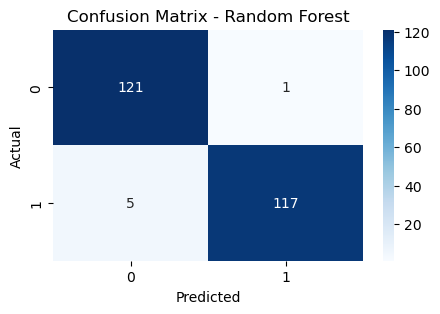

In [17]:
# Assuming clf is your trained RandomForestClassifier
#y_pred = gs_rf.predict(X_test)  # Use gs instead of clf if you want to use the grid search optimized model

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


## RF feature info

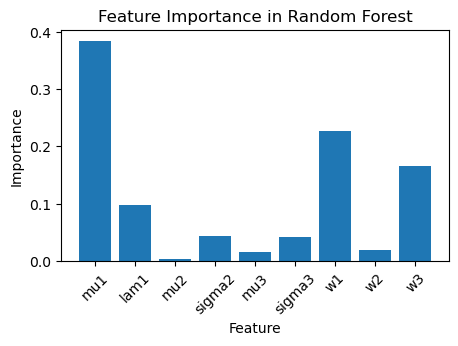

In [18]:
# Assuming X_train is your feature matrix and y_train is your target
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

feature_importances = forest.feature_importances_
feature_names = X.columns  # Assuming X is your DataFrame without the target column

plt.figure(figsize=(5, 3))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)
plt.show()


## ROC Curve

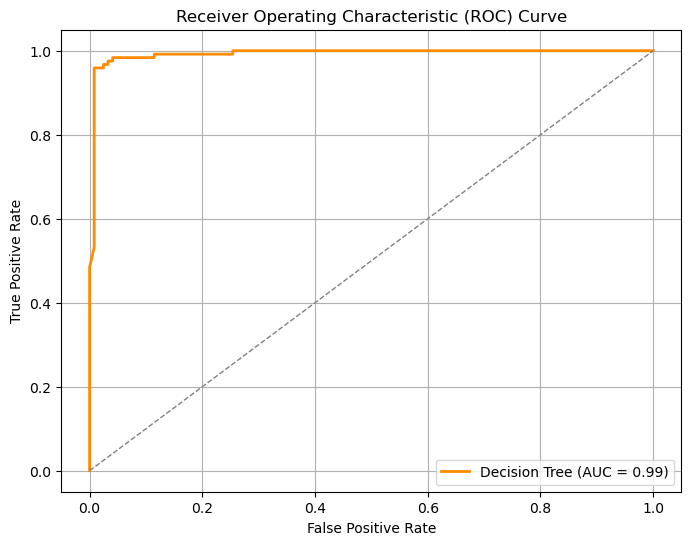

In [19]:
y_score_rf = gs_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Logistic Regression

In [20]:
params = {'C': np.logspace(-3, 3, 50), 'penalty': ['l1', 'l2']}

clf = LogisticRegression(solver='liblinear',random_state=12)

gs_logreg = GridSearchCV(clf, params, scoring='roc_auc',cv=cv,n_jobs=-1)

gs_logreg=gs_logreg.fit(X_train,y_train)
print("Best parameters set found :",gs_logreg.best_params_,'\n')

y_true, y_pred = y_test, gs_logreg.predict(X_test)

/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best parameters set found : {'C': 1000.0, 'penalty': 'l1'} 



## LR metrics

In [21]:
roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ROC AUC:  0.98
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       122
         1.0       0.99      0.97      0.98       122

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



In [22]:
y_true, y_pred = y_test, gs_logreg.predict(X_test)
accuracy_lr = round(accuracy_score(y_true, y_pred),3)
recall_lr = round(recall_score(y_true, y_pred),3)
precision_lr = round(precision_score(y_true, y_pred),3)
roc_auc_lr = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_lr)
print('Recall: ',recall_lr)
print('Precision: ',precision_lr)
print('ROC AUC: ',roc_auc_lr)

Accuracy:  0.98
Recall:  0.967
Precision:  0.992
ROC AUC:  0.98


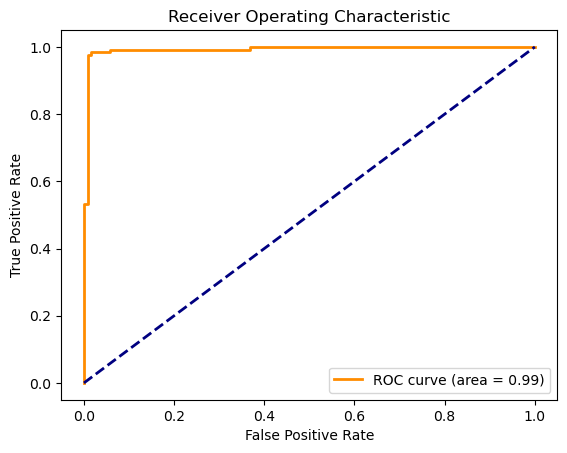

In [23]:
y_prob = gs_logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## LR matrix

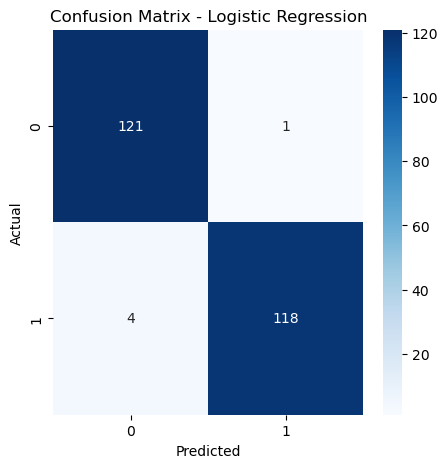

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


## LR feature info

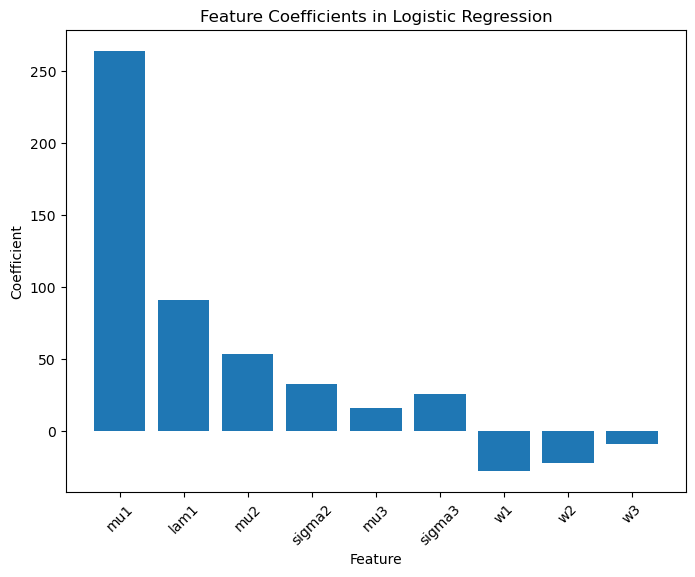

In [26]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Assuming log_reg is your trained Logistic Regression model
coefficients = gs_logreg.best_estimator_.coef_[0]  # Use gs.best_estimator_ to get the best model from grid search
feature_names = X.columns  # Assuming X is your DataFrame without the target column

plt.figure(figsize=(8, 6))
plt.bar(feature_names, coefficients)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Logistic Regression')
plt.xticks(rotation=45)
plt.show()


# SVM

In [27]:
# Define parameters for grid search
params = {'C': np.logspace(-3, 3, 50), 'kernel': ['linear', 'rbf'], 'probability': [True]}

# Define SVM classifier
clf = SVC(random_state=12)

# Create grid search object
gs_svm = GridSearchCV(clf, params, scoring='roc_auc', cv=cv, n_jobs=-1)

# Perform grid search
gs_svm = gs_svm.fit(X_train, y_train)

# Print best parameters found
print("Best parameters set found:", gs_svm.best_params_, '\n')

# Make predictions on the test set
y_true, y_pred = y_test, gs_svm.predict(X_test)

Best parameters set found: {'C': 19.306977288832496, 'kernel': 'rbf', 'probability': True} 



In [28]:
roc_auc = round(roc_auc_score(y_true, y_pred),3)
print('ROC AUC: ',roc_auc)
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

ROC AUC:  0.98
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       122
         1.0       0.98      0.98      0.98       122

    accuracy                           0.98       244
   macro avg       0.98      0.98      0.98       244
weighted avg       0.98      0.98      0.98       244



In [29]:
y_true, y_pred = y_test, gs_svm.predict(X_test)
accuracy_svm = round(accuracy_score(y_true, y_pred),3)
recall_svm = round(recall_score(y_true, y_pred),3)
precision_svm = round(precision_score(y_true, y_pred),3)
roc_auc_svm = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy_svm)
print('Recall: ',recall_svm)
print('Precision: ',precision_svm)
print('ROC AUC: ',roc_auc_svm)

Accuracy:  0.98
Recall:  0.975
Precision:  0.983
ROC AUC:  0.98


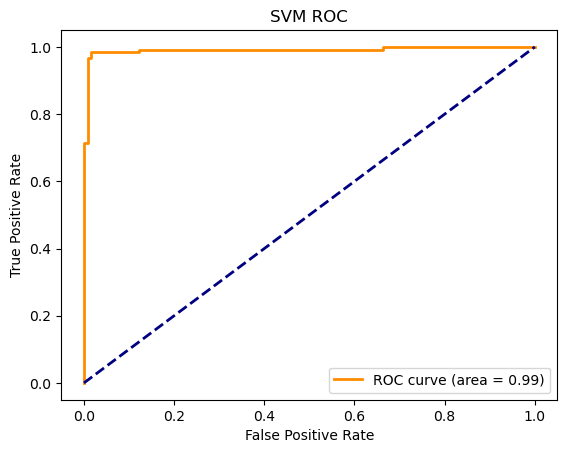

In [30]:
y_prob = gs_svm.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.legend(loc="lower right")
plt.show()

# Neural Net

In [31]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            20, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

2024-02-28 10:58:29.942995: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                200       
                                                                 
 dense_1 (Dense)             (None, 100)               2100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7401 (28.91 KB)
Trainable params: 7401 (28

In [32]:
metrics = [
    'accuracy',
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)



history=model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=200,
    validation_data=(X_test, y_test),

)

Epoch 1/200
57/57 [==============================] - 4s 20ms/step - loss: 0.2341 - accuracy: 0.8942 - fn: 31.0000 - fp: 29.0000 - tn: 255.0000 - tp: 252.0000 - precision: 0.8968 - recall: 0.8905 - val_loss: 0.2637 - val_accuracy: 0.8934 - val_fn: 25.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 97.0000 - val_precision: 0.9898 - val_recall: 0.7951
Epoch 2/200
57/57 [==============================] - 1s 12ms/step - loss: 0.1080 - accuracy: 0.9630 - fn: 11.0000 - fp: 10.0000 - tn: 274.0000 - tp: 272.0000 - precision: 0.9645 - recall: 0.9611 - val_loss: 0.0994 - val_accuracy: 0.9795 - val_fn: 4.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 118.0000 - val_precision: 0.9916 - val_recall: 0.9672
Epoch 3/200
57/57 [==============================] - 1s 11ms/step - loss: 0.0953 - accuracy: 0.9612 - fn: 11.0000 - fp: 11.0000 - tn: 273.0000 - tp: 272.0000 - precision: 0.9611 - recall: 0.9611 - val_loss: 0.1156 - val_accuracy: 0.9713 - val_fn: 6.0000 - val_fp: 1.0000 - val_tn: 121.0000 - 

57/57 [==============================] - 0s 5ms/step - loss: 0.0599 - accuracy: 0.9788 - fn: 9.0000 - fp: 3.0000 - tn: 281.0000 - tp: 274.0000 - precision: 0.9892 - recall: 0.9682 - val_loss: 0.1175 - val_accuracy: 0.9672 - val_fn: 7.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 115.0000 - val_precision: 0.9914 - val_recall: 0.9426
Epoch 25/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0761 - accuracy: 0.9753 - fn: 13.0000 - fp: 1.0000 - tn: 283.0000 - tp: 270.0000 - precision: 0.9963 - recall: 0.9541 - val_loss: 0.1375 - val_accuracy: 0.9795 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 120.0000 - val_precision: 0.9756 - val_recall: 0.9836
Epoch 26/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0684 - accuracy: 0.9753 - fn: 10.0000 - fp: 4.0000 - tn: 280.0000 - tp: 273.0000 - precision: 0.9856 - recall: 0.9647 - val_loss: 0.1057 - val_accuracy: 0.9795 - val_fn: 4.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 118.0000 

57/57 [==============================] - 0s 5ms/step - loss: 0.0362 - accuracy: 0.9912 - fn: 3.0000 - fp: 2.0000 - tn: 282.0000 - tp: 280.0000 - precision: 0.9929 - recall: 0.9894 - val_loss: 0.1363 - val_accuracy: 0.9795 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 120.0000 - val_precision: 0.9756 - val_recall: 0.9836
Epoch 48/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0537 - accuracy: 0.9859 - fn: 6.0000 - fp: 2.0000 - tn: 282.0000 - tp: 277.0000 - precision: 0.9928 - recall: 0.9788 - val_loss: 0.1564 - val_accuracy: 0.9795 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 119.0000 - val_precision: 0.9835 - val_recall: 0.9754
Epoch 49/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0654 - accuracy: 0.9841 - fn: 6.0000 - fp: 3.0000 - tn: 281.0000 - tp: 277.0000 - precision: 0.9893 - recall: 0.9788 - val_loss: 0.1181 - val_accuracy: 0.9836 - val_fn: 3.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 119.0000 - 

57/57 [==============================] - 0s 5ms/step - loss: 0.0556 - accuracy: 0.9824 - fn: 6.0000 - fp: 4.0000 - tn: 280.0000 - tp: 277.0000 - precision: 0.9858 - recall: 0.9788 - val_loss: 0.1639 - val_accuracy: 0.9549 - val_fn: 1.0000 - val_fp: 10.0000 - val_tn: 112.0000 - val_tp: 121.0000 - val_precision: 0.9237 - val_recall: 0.9918
Epoch 71/200
57/57 [==============================] - 0s 7ms/step - loss: 0.0418 - accuracy: 0.9894 - fn: 4.0000 - fp: 2.0000 - tn: 282.0000 - tp: 279.0000 - precision: 0.9929 - recall: 0.9859 - val_loss: 0.1198 - val_accuracy: 0.9795 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 120.0000 - val_precision: 0.9756 - val_recall: 0.9836
Epoch 72/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0739 - accuracy: 0.9683 - fn: 12.0000 - fp: 6.0000 - tn: 278.0000 - tp: 271.0000 - precision: 0.9783 - recall: 0.9576 - val_loss: 0.1569 - val_accuracy: 0.9672 - val_fn: 7.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 115.0000 

57/57 [==============================] - 0s 4ms/step - loss: 0.0393 - accuracy: 0.9824 - fn: 6.0000 - fp: 4.0000 - tn: 280.0000 - tp: 277.0000 - precision: 0.9858 - recall: 0.9788 - val_loss: 0.1906 - val_accuracy: 0.9713 - val_fn: 6.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 116.0000 - val_precision: 0.9915 - val_recall: 0.9508
Epoch 94/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9824 - fn: 8.0000 - fp: 2.0000 - tn: 282.0000 - tp: 275.0000 - precision: 0.9928 - recall: 0.9717 - val_loss: 0.1549 - val_accuracy: 0.9795 - val_fn: 3.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 119.0000 - val_precision: 0.9835 - val_recall: 0.9754
Epoch 95/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0429 - accuracy: 0.9824 - fn: 5.0000 - fp: 5.0000 - tn: 279.0000 - tp: 278.0000 - precision: 0.9823 - recall: 0.9823 - val_loss: 0.1664 - val_accuracy: 0.9795 - val_fn: 2.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 120.0000 - 

57/57 [==============================] - 0s 5ms/step - loss: 0.0492 - accuracy: 0.9877 - fn: 6.0000 - fp: 1.0000 - tn: 283.0000 - tp: 277.0000 - precision: 0.9964 - recall: 0.9788 - val_loss: 0.1836 - val_accuracy: 0.9836 - val_fn: 2.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 120.0000 - val_precision: 0.9836 - val_recall: 0.9836
Epoch 117/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9771 - fn: 6.0000 - fp: 7.0000 - tn: 277.0000 - tp: 277.0000 - precision: 0.9754 - recall: 0.9788 - val_loss: 0.1668 - val_accuracy: 0.9795 - val_fn: 4.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 118.0000 - val_precision: 0.9916 - val_recall: 0.9672
Epoch 118/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0422 - accuracy: 0.9806 - fn: 9.0000 - fp: 2.0000 - tn: 282.0000 - tp: 274.0000 - precision: 0.9928 - recall: 0.9682 - val_loss: 0.1647 - val_accuracy: 0.9795 - val_fn: 4.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 118.0000 

57/57 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.9824 - fn: 7.0000 - fp: 3.0000 - tn: 281.0000 - tp: 276.0000 - precision: 0.9892 - recall: 0.9753 - val_loss: 0.1830 - val_accuracy: 0.9836 - val_fn: 3.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 119.0000 - val_precision: 0.9917 - val_recall: 0.9754
Epoch 140/200
57/57 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9877 - fn: 3.0000 - fp: 4.0000 - tn: 280.0000 - tp: 280.0000 - precision: 0.9859 - recall: 0.9894 - val_loss: 0.1887 - val_accuracy: 0.9754 - val_fn: 5.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 117.0000 - val_precision: 0.9915 - val_recall: 0.9590
Epoch 141/200
57/57 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9877 - fn: 7.0000 - fp: 0.0000e+00 - tn: 284.0000 - tp: 276.0000 - precision: 1.0000 - recall: 0.9753 - val_loss: 0.2007 - val_accuracy: 0.9836 - val_fn: 2.0000 - val_fp: 2.0000 - val_tn: 120.0000 - val_tp: 120.0

57/57 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9877 - fn: 4.0000 - fp: 3.0000 - tn: 281.0000 - tp: 279.0000 - precision: 0.9894 - recall: 0.9859 - val_loss: 0.2926 - val_accuracy: 0.9713 - val_fn: 2.0000 - val_fp: 5.0000 - val_tn: 117.0000 - val_tp: 120.0000 - val_precision: 0.9600 - val_recall: 0.9836
Epoch 163/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0272 - accuracy: 0.9894 - fn: 3.0000 - fp: 3.0000 - tn: 281.0000 - tp: 280.0000 - precision: 0.9894 - recall: 0.9894 - val_loss: 0.2917 - val_accuracy: 0.9754 - val_fn: 5.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 117.0000 - val_precision: 0.9915 - val_recall: 0.9590
Epoch 164/200
57/57 [==============================] - 1s 9ms/step - loss: 0.0245 - accuracy: 0.9929 - fn: 4.0000 - fp: 0.0000e+00 - tn: 284.0000 - tp: 279.0000 - precision: 1.0000 - recall: 0.9859 - val_loss: 0.3764 - val_accuracy: 0.9754 - val_fn: 5.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 117.0

57/57 [==============================] - 0s 5ms/step - loss: 0.1057 - accuracy: 0.9700 - fn: 11.0000 - fp: 6.0000 - tn: 278.0000 - tp: 272.0000 - precision: 0.9784 - recall: 0.9611 - val_loss: 0.3538 - val_accuracy: 0.9672 - val_fn: 1.0000 - val_fp: 7.0000 - val_tn: 115.0000 - val_tp: 121.0000 - val_precision: 0.9453 - val_recall: 0.9918
Epoch 186/200
57/57 [==============================] - 0s 4ms/step - loss: 0.0515 - accuracy: 0.9824 - fn: 8.0000 - fp: 2.0000 - tn: 282.0000 - tp: 275.0000 - precision: 0.9928 - recall: 0.9717 - val_loss: 0.2156 - val_accuracy: 0.9754 - val_fn: 3.0000 - val_fp: 3.0000 - val_tn: 119.0000 - val_tp: 119.0000 - val_precision: 0.9754 - val_recall: 0.9754
Epoch 187/200
57/57 [==============================] - 0s 5ms/step - loss: 0.0678 - accuracy: 0.9753 - fn: 11.0000 - fp: 3.0000 - tn: 281.0000 - tp: 272.0000 - precision: 0.9891 - recall: 0.9611 - val_loss: 0.2321 - val_accuracy: 0.9754 - val_fn: 5.0000 - val_fp: 1.0000 - val_tn: 121.0000 - val_tp: 117.000

dict_keys(['loss', 'accuracy', 'fn', 'fp', 'tn', 'tp', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_fn', 'val_fp', 'val_tn', 'val_tp', 'val_precision', 'val_recall'])


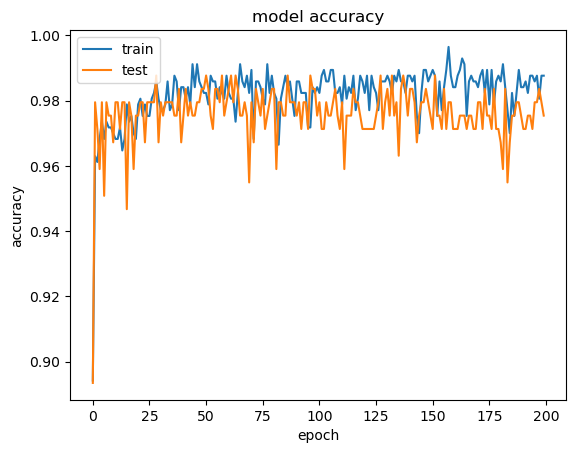

In [33]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
y_pred_probabilities = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_probabilities > threshold).astype(int)
y_true= y_test

accuracy = round(accuracy_score(y_true, y_pred),3)
recall = round(recall_score(y_true, y_pred),3)
precision = round(precision_score(y_true, y_pred),3)
roc_auc = round(roc_auc_score(y_true, y_pred),3)

print('Accuracy: ',accuracy)
print('Recall: ',recall)
print('Precision: ',precision)
print('ROC AUC: ',roc_auc)

8/8 [==============================] - 0s 3ms/step
Accuracy:  0.975
Recall:  0.959
Precision:  0.992
ROC AUC:  0.975


In [40]:
np.shape(y_pred_probabilities)

(244, 1)

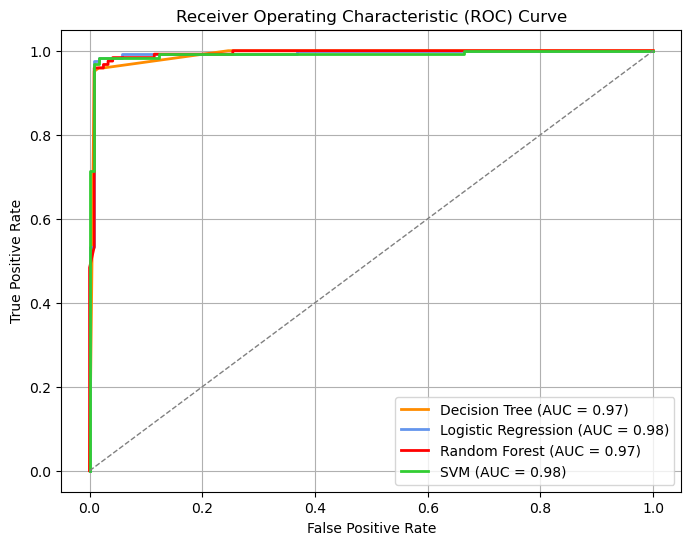

In [64]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ct, tpr_ct, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_ct:.2f})')
plt.plot(fpr_lr, tpr_lr, color='cornflowerblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, color='limegreen', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
#plt.plot(fpr_lr, tpr_lr, color='cornflowerblue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('all_ROC.jpg')
plt.show()

In [47]:
print('Decision Tree: ')
print('Accuracy: ',accuracy_ct)
print('Recall: ',recall_ct)
print('Precision: ',precision_ct)
print('ROC AUC: ',roc_auc_ct)

print('Logistic Regression')
print('Accuracy: ',accuracy_lr)
print('Recall: ',recall_lr)
print('Precision: ',precision_lr)
print('ROC AUC: ',roc_auc_lr)


print('Random Forest')
print('Accuracy: ',accuracy_rf)
print('Recall: ',recall_rf)
print('Precision: ',precision_rf)
print('ROC AUC: ',roc_auc_rf)

print('Support Vector Machine: ')
print('Accuracy: ',accuracy_svm)
print('Recall: ',recall_svm)
print('Precision: ',precision_svm)
print('ROC AUC: ',roc_auc_svm)


Decision Tree: 
Accuracy:  0.971
Recall:  0.959
Precision:  0.983
ROC AUC:  0.971
Logistic Regression
Accuracy:  0.98
Recall:  0.967
Precision:  0.992
ROC AUC:  0.98
Random Forest
Accuracy:  0.975
Recall:  0.959
Precision:  0.992
ROC AUC:  0.975
Support Vector Machine: 
Accuracy:  0.98
Recall:  0.975
Precision:  0.983
ROC AUC:  0.98


In [41]:
print('Decision Tree: ',accuracy_ct)
print('-->>      Logistic Regression',accuracy_lr)
print('Random Forest',accuracy_rf)
print('-->> Support Vector Machine: ',accuracy_svm)

Decision Tree:  0.971
-->>      Logistic Regression 0.98
Random Forest 0.975
-->> Support Vector Machine:  0.98


In [44]:
print('Decision Tree: ',recall_ct)
print('-->>      Logistic Regression',recall_lr)
print('Random Forest',recall_rf)
print('-->> Support Vector Machine: ',recall_svm)


Decision Tree:  0.959
-->>      Logistic Regression 0.967
Random Forest 0.959
-->> Support Vector Machine:  0.975


In [51]:
print('Decision Tree: ',precision_ct)
print('-->>    Logistic Regression',precision_lr)
print('-->>          Random Forest',precision_rf)
print('Support Vector Machine: ',precision_svm)


Decision Tree:  0.983
-->>    Logistic Regression 0.992
-->>          Random Forest 0.992
Support Vector Machine:  0.983


In [54]:
print('Decision Tree: ',roc_auc_ct)
print('-->>      Logistic Regression',roc_auc_lr)
print('Random Forest',roc_auc_rf)
print('-->> Support Vector Machine: ',roc_auc_svm)


Decision Tree:  0.971
-->>      Logistic Regression 0.98
Random Forest 0.975
-->> Support Vector Machine:  0.98
